<a href="https://colab.research.google.com/github/JNishimura/Deep-Learning-Recommenders/blob/main/Notebooks/MovieLens_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installs

In [2]:
!pip install pandas
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann
!pip install ipywidgets

     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 394.7MB 38kB/s 
     |████████████████████████████████| 3.7MB 4.4MB/s 
     |████████████████████████████████| 11.1MB 5.0MB/s 


### Imports

In [3]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import math
import heapq

### Data Set-up

In [4]:
# Ratings data.
ratings = tfds.load("movielens/100k-ratings", split="train")

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [5]:
for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


In [6]:
dataframe = tfds.as_dataframe(ratings)
print(dataframe)

       bucketized_user_age     movie_genres  ... user_rating user_zip_code
0                     45.0              [7]  ...         4.0      b'53211'
1                     25.0          [4, 14]  ...         2.0      b'80525'
2                     18.0              [4]  ...         4.0      b'55439'
3                     50.0           [5, 7]  ...         4.0      b'06472'
4                     50.0         [10, 16]  ...         3.0      b'75094'
...                    ...              ...  ...         ...           ...
99995                 25.0       [0, 1, 15]  ...         4.0      b'80027'
99996                 35.0         [13, 16]  ...         4.0      b'60035'
99997                 18.0             [10]  ...         1.0      b'78264'
99998                 35.0  [0, 10, 15, 16]  ...         4.0      b'53210'
99999                 18.0              [4]  ...         2.0      b'95064'

[100000 rows x 12 columns]


In [7]:
# Pull out relevant columns and convert id columns to ints
relevant_cols = dataframe.loc[:, ['user_id', 'movie_id', 'user_rating', 'timestamp']]
relevant_cols['user_id'] = relevant_cols['user_id'].astype(int)
relevant_cols['movie_id'] = relevant_cols['movie_id'].astype(int)
print(relevant_cols)
print(relevant_cols.dtypes)

       user_id  movie_id  user_rating  timestamp
0          138       357          4.0  879024327
1           92       709          2.0  875654590
2          301       412          4.0  882075110
3           60        56          4.0  883326919
4          197       895          3.0  891409199
...        ...       ...          ...        ...
99995      774       228          4.0  888557237
99996      313       333          4.0  891012877
99997      262       567          1.0  879795430
99998      911       183          4.0  892839492
99999      276      1140          2.0  874791894

[100000 rows x 4 columns]
user_id          int64
movie_id         int64
user_rating    float64
timestamp        int64
dtype: object


In [8]:
relevant_cols['latest'] = relevant_cols.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)

train_ratings = relevant_cols[relevant_cols['latest'] != 1]
test_ratings = relevant_cols[relevant_cols['latest'] == 1]

train_ratings = train_ratings[['user_id', 'movie_id', 'user_rating']][:1000]
test_ratings = test_ratings[['user_id', 'movie_id', 'user_rating']][:100]

print(train_ratings.shape)
print(test_ratings.shape)

num_users = len(relevant_cols.user_id.unique()) + 1
num_items = len(relevant_cols.movie_id.unique()) + 1

print('Num Users:', num_users)
print('Num Items:', num_items)

(1000, 3)
(100, 3)
Num Users: 944
Num Items: 1683


## Convert to Implicit Feedback Dataset

In [9]:
# Convert rating to 1 for everything to mark that the user has watched this item
train_ratings.loc[:, 'rating'] = 1
print(train_ratings)


      user_id  movie_id  user_rating  rating
0         138       357          4.0       1
1          92       709          2.0       1
2         301       412          4.0       1
3          60        56          4.0       1
4         197       895          3.0       1
...       ...       ...          ...     ...
1024       91        69          5.0       1
1025      463       475          3.0       1
1026       77       527          4.0       1
1027      121       508          4.0       1
1028      788       540          3.0       1

[1000 rows x 4 columns]


In [10]:
# Add negative samples
all_movies = relevant_cols['movie_id'].unique()

users, items, labels = [], [], []
user_item_set = set(zip(train_ratings['user_id'], train_ratings['movie_id']))
num_negatives = 4

for (u, i) in user_item_set:
  users.append([u])
  items.append([i])
  labels.append([1])
  for _ in range(num_negatives):
    negative_item = np.random.choice(all_movies)
    while (u, negative_item) in user_item_set:
      negative_item = np.random.choice(all_movies)
    users.append([u])
    items.append([negative_item])
    labels.append([0])



## Create Dataset

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices(({'user': users, 'item': items}, labels))

In [12]:
train_ds = train_ds.shuffle(1000)
for elem in train_ds.take(10):
  print(elem)


({'user': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([457], dtype=int32)>, 'item': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1407], dtype=int32)>}, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)
({'user': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([450], dtype=int32)>, 'item': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([904], dtype=int32)>}, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)
({'user': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([13], dtype=int32)>, 'item': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([370], dtype=int32)>}, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)
({'user': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([938], dtype=int32)>, 'item': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([565], dtype=int32)>}, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)
({'user': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([334], dtype=int32)>,

In [13]:
BATCH_SIZE = 28

## Define Model

In [14]:
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Reshape, Multiply, Flatten, Lambda, Concatenate, Layer, Dropout, Average
from keras import initializers, regularizers
import sys

def get_GMFmodel(num_users, num_items, latent_dim):
  user_input = Input(shape = (1,), dtype = 'int32', name = 'user')
  item_input = Input(shape = (1,), dtype = 'int32', name = 'item')

  user_embedding = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)
  item_embedding = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)

  user_latent = Flatten()(user_embedding(user_input))
  item_latent = Flatten()(item_embedding(item_input))

  prediction_vec = Multiply()([user_latent, item_latent])

  prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(prediction_vec)

  return Model(inputs=[user_input, item_input], outputs=prediction)

In [15]:
def get_MLPmodel(num_users, num_items, latent_dim):
  user_input = Input(shape = (1,), dtype = 'int32', name = 'user')
  item_input = Input(shape = (1,), dtype = 'int32', name = 'item')

  user_embedding = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)
  item_embedding = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)
  
  user_latent = Flatten()(user_embedding(user_input))
  item_latent = Flatten()(item_embedding(item_input))

  inputs = Concatenate()([user_latent, item_latent])

  layer = Dense(256, activation='relu', name='Layer1', kernel_initializer='glorot_uniform')(inputs)

  layer = Dense(128, activation='relu', name='Layer2')(layer)
  dropout2 = Dropout(.1, noise_shape=(1, 128))(layer)
  layer = Dense(64, activation='relu', name='Layer5')(dropout2)
  
  # layer = Dense(32, activation='relu', name='Layer3')(layer)
  output = Dense(1, activation='sigmoid', name='Layer4')(layer)

  return Model(inputs=[user_input, item_input], outputs=output)
    

In [16]:
from keras.optimizers import Adam

topK = 10

model = get_MLPmodel(num_users, num_items, 8)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embed (Embedding)          (None, 1, 8)         7552        user[0][0]                       
__________________________________________________________________________________________________
item_embed (Embedding)          (None, 1, 8)         13464       item[0][0]                       
______________________________________________________________________________________________

In [17]:
hist = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=10)

Epoch 1/10
5000/5000 [==============================] - 12s 2ms/step - loss: 0.5114 - binary_accuracy: 0.8031
Epoch 2/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.3755 - binary_accuracy: 0.8235
Epoch 3/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.3235 - binary_accuracy: 0.8407
Epoch 4/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.2826 - binary_accuracy: 0.8619
Epoch 5/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.2531 - binary_accuracy: 0.8715
Epoch 6/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.2219 - binary_accuracy: 0.8924
Epoch 7/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.1916 - binary_accuracy: 0.9139
Epoch 8/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1556 - binary_accuracy: 0.9262
Epoch 9/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1219 - binary_accuracy: 0.9446
Epoch 10/1

In [18]:
hist.history

{'binary_accuracy': [0.800000011920929,
  0.8241999745368958,
  0.842199981212616,
  0.8614000082015991,
  0.8791999816894531,
  0.9010000228881836,
  0.9182000160217285,
  0.9297999739646912,
  0.9458000063896179,
  0.9610000252723694],
 'loss': [0.49833256006240845,
  0.3883223235607147,
  0.33120548725128174,
  0.2858979105949402,
  0.2494353950023651,
  0.21373000741004944,
  0.18122103810310364,
  0.14818744361400604,
  0.12116577476263046,
  0.0958435982465744]}

In [19]:
class Combine(Layer):
  def __init__(self):
        super(Combine, self).__init__()
        random_alpha = tf.random.uniform(shape=[1])
        self.alpha = tf.Variable(initial_value=random_alpha, trainable=True)
  
  def call(self, inputs):
    return (1 - self.alpha)*inputs[0] + self.alpha*inputs[1]

In [20]:
def get_MLPGMFmodel(num_users, num_items, latent_dim):
  user_input = Input(shape = (1,), dtype = 'int32', name = 'user')
  movie_input = Input(shape = (1,), dtype = 'int32', name = 'item')

  user_embedding = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)
  movie_embedding = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embed',
                             embeddings_initializer = initializers.RandomNormal(stddev = 0.01), 
                             embeddings_regularizer = regularizers.l2(0), input_length = 1)
  
  user_latent = Flatten()(user_embedding(user_input))
  item_latent = Flatten()(movie_embedding(movie_input))

  #GMF 
  prediction_vec = Multiply()([user_latent, item_latent])
  prediction_GMF = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(prediction_vec)

  #MLF
  inputs = Concatenate()([user_latent, item_latent])
  layer = Dense(512, activation='relu', name='Layer1', kernel_initializer='glorot_uniform')(inputs)

  layer = Dense(128, activation='relu', name='Layer2')(layer)
  layer = Dense(64, activation='relu', name='Layer5')(layer)
  # dropout2 = Dropout(.2)(layer)
  layer = Dense(32, activation='relu', name='Layer3')(layer)
  layer2 = Dense(32, activation='relu', name='Layer12')(layer)
  avg = Average()([layer, layer2])
  prediction_MLP = Dense(1, activation='sigmoid', name='Layer4')(avg)

  predictions = Combine()([prediction_GMF, prediction_MLP])

  return Model(inputs=[user_input, movie_input], outputs=predictions)


In [21]:
def evaluateNCDG(ranked_list, target_item):
  for i in range(len(ranked_list)):
    if ranked_list[i] == target_item:
      return math.log(2) / math.log(i + 2)
  
  return 0

In [22]:
def hitRate(item, ranklist):
  for rank in ranklist:
    if item == rank:
      return 1
  return 0

In [23]:
all_movies = relevant_cols['movie_id'].unique()

users, items, labels = [], [], []
user_item_set = set(zip(train_ratings['user_id'], train_ratings['movie_id']))
user_set = set(train_ratings['user_id'])
num_test_negatives = 100
test_negatives = {}

for u in user_set:
  negatives = []

  for _ in range(num_test_negatives):
    negative_item = np.random.choice(all_movies)
    while (u, negative_item) in user_item_set:
      negative_item = np.random.choice(all_movies)
    
    negatives.append(negative_item)
  
  test_negatives[u] = negatives

print('Number of users:', len(test_negatives))
print('Number of negative points:', len(test_negatives[138]))

def evaluate_model(model, N=10):
  hits = []
  ncdgs = []
  completed = 0

  for (u, item) in zip(test_ratings['user_id'], test_ratings['movie_id']):
    if u in test_negatives:
      negs = test_negatives[u]
      test_negs = np.array([])
      test_users = np.array([])
      items = {}

      for neg in negs:
        test_negs = np.append(test_negs, tf.constant([neg]))
        test_users = np.append(test_users, tf.constant([u]))
      test_negs = np.append(test_negs, tf.constant([item]))
      test_users = np.append(test_users, tf.constant([u]))

      predictions = model.predict({'user': test_users, 'item': test_negs})
      completed += 1

      for i in range(len(predictions)):
        if i == len(predictions) - 1:
          items[item] = predictions[i]
        else:
          items[negs[i]] = predictions[i]

      rankedList = heapq.nlargest(N, items, items.get)

      ncdg = evaluateNCDG(rankedList, item)
      hit = hitRate(item, rankedList)
      
      ncdgs.append(ncdg)
      hits.append(hit)

    
    hit_rate = np.mean(hits)
    mean_ncdg = np.mean(ncdgs)

  return hit_rate, mean_ncdg

Number of users: 504
Number of negative points: 100


In [24]:
NUM_EPOCHS = 1
best_hr = 0
best_ncdg = 0
best_epoch = -1
model_path = "OP_model.h5"

for epoch in range(1, NUM_EPOCHS + 1):
  hist = model.fit(train_ds, batch_size=256, epochs=1)

  hit_rate, ncdg = evaluate_model(model)
  print('Epoch', epoch, 'Hit Rate:', hit_rate, 'NCDG:', ncdg)


5000/5000 [==============================] - 11s 2ms/step - loss: 0.0722 - binary_accuracy: 0.9710


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 1 Hit Rate: 0.23809523809523808 NCDG: 0.14273450600100795


ValueError: ignored

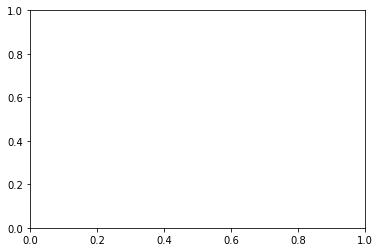

In [25]:
import matplotlib.pyplot as plt
x = np.arange(1, 11)
plt.plot(x,hist.history['binary_accuracy'], 'bo')
plt.plot(x,hist.history['loss'], 'r+')
plt.xticks(x)
plt.title('Loss and accuracy for the NeuMF model')

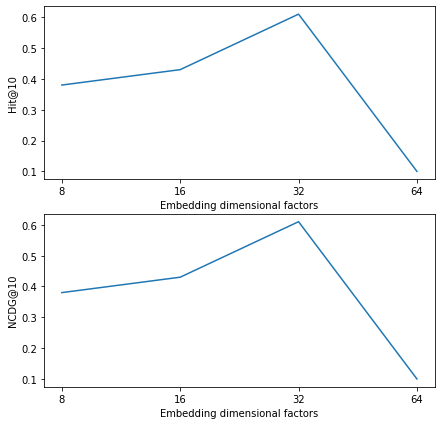

In [36]:
x = [8, 16,32, 64]
y = [0.38, .43,.61,.1]
fig = plt.figure(1, figsize=(7,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.axes.set_xlabel('Embedding dimensional factors')
ax1.axes.set_ylabel('Hit@10')
ax1.axes.set_xticks([0,1,2,3])
ax1.axes.set_xticklabels(x)
ax1.plot(y)
ax2.axes.set_xlabel('Embedding dimensional factors')
ax2.axes.set_ylabel('NCDG@10')
ax2.axes.set_xticks([0,1,2,3])
ax2.axes.set_xticklabels(x)
ax2.plot(y)
